In [1]:
""" ACTIVE JUPYTER NOTEBOOK TO PERFORM QUALITY CONTROL FOLLOWING UNIT MATCHING """

' ACTIVE JUPYTER NOTEBOOK TO PERFORM QUALITY CONTROL FOLLOWING UNIT MATCHING '

In [2]:
# Outside imports
import os, sys
import numpy as np
import matplotlib.pyplot as plt

# Set necessary paths / make project path = ...../neuroscikit/
unit_matcher_path = os.getcwd()
prototype_path = os.path.abspath(os.path.join(unit_matcher_path, os.pardir))
project_path = os.path.abspath(os.path.join(prototype_path, os.pardir))
lab_path = os.path.abspath(os.path.join(project_path, os.pardir))
sys.path.append(project_path)
os.chdir(project_path)
print(project_path)

# Internal imports

# Read write modules
from x_io.rw.axona.batch_read import make_study
from _prototypes.unit_matcher.read_axona import read_sequential_sessions, temp_read_cut
from _prototypes.unit_matcher.write_axona import format_new_cut_file_name

# Unit matching modules
from _prototypes.unit_matcher.main import format_cut, run_unit_matcher, map_unit_matches_first_session, map_unit_matches_sequential_session
from _prototypes.unit_matcher.session import compare_sessions
from _prototypes.unit_matcher.waveform import time_index, derivative, derivative2, morphological_points

c:\Users\aaoun\OneDrive - cumc.columbia.edu\Desktop\HussainiLab\neuroscikit


In [3]:
""" If a setting is not used for your analysis (e.g. smoothing_factor), just pass in an arbitrary value or pass in 'None' """
STUDY_SETTINGS = {

    'ppm': 511,  # EDIT HERE

    'smoothing_factor': None, # EDIT HERE

    'useMatchedCut': False,  # EDIT HERE, set to False if you want to use runUnitMatcher, set to True after to load in matched.cut file
}


# Switch devices to True/False based on what is being used (to be extended for more devices in future)
device_settings = {'axona_led_tracker': True, 'implant': True} 

# Make sure implant metadata is correct, change if not, AT THE MINIMUM leave implant_type: tetrode
implant_settings = {'implant_type': 'tetrode', 'implant_geometry': 'square', 'wire_length': 25, 'wire_length_units': 'um', 'implant_units': 'uV'}

# WE ASSUME DEVICE AND IMPLANT SETTINGS ARE CONSISTENCE ACROSS SESSIONS, IF THIS IS NOT THE CASE PLEASE LET ME KNOW

# Set channel count + add device/implant settings
SESSION_SETTINGS = {
    'channel_count': 4, # EDIT HERE, default is 4, you can change to other number but code will check how many tetrode files are present and set that to channel copunt regardless
    'devices': device_settings, # EDIT HERE
    'implant': implant_settings, # EDIT HERE
}

STUDY_SETTINGS['session'] = SESSION_SETTINGS

settings_dict = STUDY_SETTINGS

In [4]:
""" MAKE DATA DIR THE SAME PATH AS THE ONE USED IN THE UNIT MATCHER """

# Note: if you only want to verify a certain amount of sessions from the full unit matching process 
# 1) either make a separate folder with only the tetrode files (+ set + pos + cut + matched.cut) that you want to look at 
# 2) or load in the full study and use session id/animal id to pull out the speciffic sessions you want 
# (if too difficult can add a function to take a file path or id and return the session in question)
data_dir = lab_path + r'\neuroscikit_test_data\20180502-ROUND-3000'
# data_dir = lab_path + r'\neuroscikit_test_data\single_sequential'

In [5]:
settings_dict_unmatched = settings_dict
settings_dict_unmatched['useMatchedCut'] = False

unmatched_study = make_study([data_dir], settings_dict_unmatched)
unmatched_study.make_animals()

Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell


In [6]:
# To use for loading in matched cut and vizualizing / subsequent analysis
settings_dict_matched = settings_dict
settings_dict_matched['useMatchedCut'] = True

matched_study = make_study([data_dir], settings_dict_matched)
matched_study.make_animals()

Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Animal ID set
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell
Session data added, spikes sorted by cell


In [7]:
matched_study_animal_ids = matched_study.animal_ids
unmatched_study_animal_ids = unmatched_study.animal_ids
matched_study_animals = matched_study.animals
unmatched_study_animals = unmatched_study.animals

print('Matched Animal IDs:' + str(sorted(matched_study_animal_ids)))
print('Unmatched Animal IDs: ' + str(sorted(unmatched_study_animal_ids)))

Matched Animal IDs:['20180502-ROUND-3000_tet1', '20180502-ROUND-3000_tet1', '20180502-ROUND-3000_tet2', '20180502-ROUND-3000_tet2', '20180502-ROUND-3000_tet3', '20180502-ROUND-3000_tet3', '20180502-ROUND-3000_tet4', '20180502-ROUND-3000_tet4']
Unmatched Animal IDs: ['20180502-ROUND-3000_tet1', '20180502-ROUND-3000_tet1', '20180502-ROUND-3000_tet2', '20180502-ROUND-3000_tet2', '20180502-ROUND-3000_tet3', '20180502-ROUND-3000_tet3', '20180502-ROUND-3000_tet4', '20180502-ROUND-3000_tet4']


In [8]:
all_colors = ['b', 'lightgreen', 'r', 'purple', 'cyan', 'darkgreen', 'brown', 'aquamarine', 'indigo', 'gold', 'maroon', 'yellow', 'grey', 'lightblue', 'pink']

In [13]:
from _prototypes.unit_matcher.write_axona import apply_remapping, write_cut


def qualityCheck(matched_study, unmatched_study):

    print(matched_study.animal_ids)
    animal_id_to_use = str(input('Choose animal id from printed options'))
    idx = np.where(animal_id_to_use in matched_study.animal_ids)[0][0]
    print('Animal Sessions: ' + str(np.asarray(matched_study.animals)[idx].sessions.keys()))
    ses1_id = str(input('Choose first session id from animal sessions'))
    ses2_id = str(input('Choose second session id from animal sessions'))


    # animal_id_to_use = '20180502-ROUND-3000_tet1'
    # ses1_id = 'session_1'
    # ses2_id = 'session_2'

    unmatched_animal = unmatched_study.get_animal_by_id(animal_id_to_use)
    matched_animal = matched_study.get_animal_by_id(animal_id_to_use)
    # unmatched_animal = np.asarray(unmatched_study.animals)[idx]
    # matched_animal = np.asarray(matched_study.animals)[idx]

    ses1_unmatched = unmatched_animal.sessions[ses1_id]
    ses2_unmatched = unmatched_animal.sessions[ses2_id]

    ses1_matched = matched_animal.sessions[ses1_id]
    ses2_matched = matched_animal.sessions[ses2_id]

    ses1_new_cut = ses1_matched.session_metadata.file_paths['cut']
    ses2_new_cut = ses1_matched.session_metadata.file_paths['cut']

    ses1_old_cells = ses1_unmatched.get_cell_data()['cell_ensemble']
    ses2_old_cells = ses2_unmatched.get_cell_data()['cell_ensemble']

    ses1_new_cells = ses1_matched.get_cell_data()['cell_ensemble']
    ses2_new_cells = ses2_matched.get_cell_data()['cell_ensemble']

    assert len(ses1_old_cells.cells) == len(ses1_new_cells.cells)
    assert len(ses2_old_cells.cells) == len(ses2_new_cells.cells)

    col_count = 5
    row_count = 4

    make_plot(ses1_unmatched, ses1_old_cells, row_count, col_count, 'Session 1 Pre-Matching')
    make_plot(ses2_unmatched, ses2_old_cells, row_count, col_count, 'Session 2 Pre-Matching')
    make_plot(ses1_matched, ses1_new_cells, row_count, col_count, 'Session 1 Post-Matching')
    make_plot(ses2_matched, ses2_new_cells, row_count, col_count, 'Session 2 Post-Matching')

    answer = str(input('Would you like to swap any cell labels? Answer Y/N'))
    proceed = False
    if answer == 'Y' or answer == 'Yes' or answer == 'y' or answer == 'yes':
        proceed = True
    if proceed == True:
        session_answer = str(input('Enter the session_id that holds the cells'))
        cell_1 = str(input('Enter the NEW cell label of the first cell you would like to change'))
        cell_2 = str(input('Enter the NEW cell label of the second cell you would like to change'))

        chosen_session = matched_animal.sessions[session_answer]

        chosen_session = matched_animal.sessions[session_answer]

        map_dict = {}
        for cell in chosen_session.get_cell_data()['cell_ensemble'].cells:
            if cell.cluster == cell_1:
                map_dict[cell_1] == cell_2
            elif cell.cluster == cell_2:
                map_dict[cell_2] == cell_1
            else:
                map_dict[cell.cluster] = cell.cluster

        matched_cut_file_path, new_data, header_data = format_cut(chosen_session, map_dict)
        write_cut(matched_cut_file_path, new_data, header_data)

        

    

    

def make_plot(ses, ensemble, row_count, col_count, title):


    figSes = plt.figure(figsize=(18, 5))
    figSes.suptitle(title)
    for i in range(len(ensemble.cells)):
        cell = ensemble.cells[i]
        waveforms = cell.signal

        mn = np.min(waveforms)
        mx = np.max(waveforms)

        for k in range(len(cell.signal[0])):
            axOldSes1 = figSes.add_subplot(int(np.ceil(len(ensemble.cells) / col_count) * row_count), col_count, int(i + 1 + k * col_count))
            channel_signal = waveforms[:,int(k),:]
            avg_signal = np.mean(channel_signal, axis=0)
            # axOldSes1.plot(channel_signal.T, color='gray', lw=0.5, alpha=0.3)
            axOldSes1.plot(avg_signal, color=all_colors[i], lw=2)
            axOldSes1.set_title('Cell ' + str(i+1) + ', Channel ' + str(k+1) + ', Spk Count ' + str(len(cell.event_times)))

    figSes.tight_layout()
    plt.show()
    

['20180502-ROUND-3000_tet1', '20180502-ROUND-3000_tet2', '20180502-ROUND-3000_tet3', '20180502-ROUND-3000_tet4', '20180502-ROUND-3000_tet1', '20180502-ROUND-3000_tet2', '20180502-ROUND-3000_tet3', '20180502-ROUND-3000_tet4']
Animal Sessions: dict_keys(['session_1', 'session_2'])


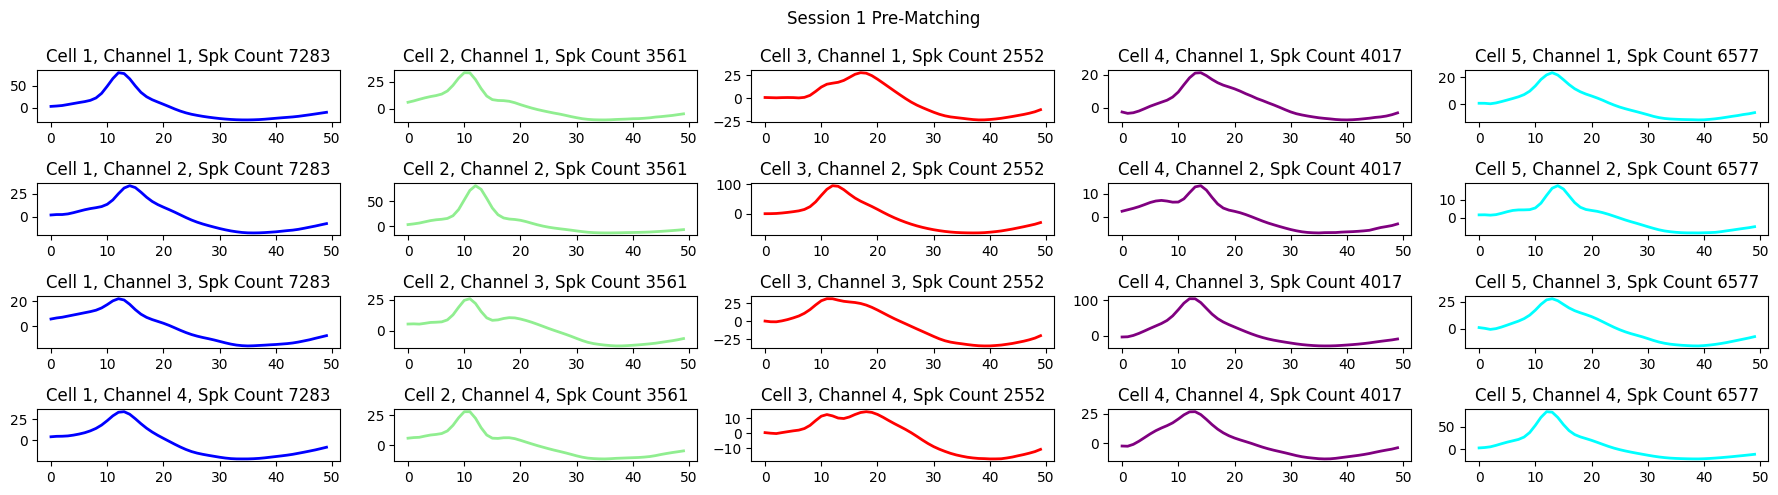

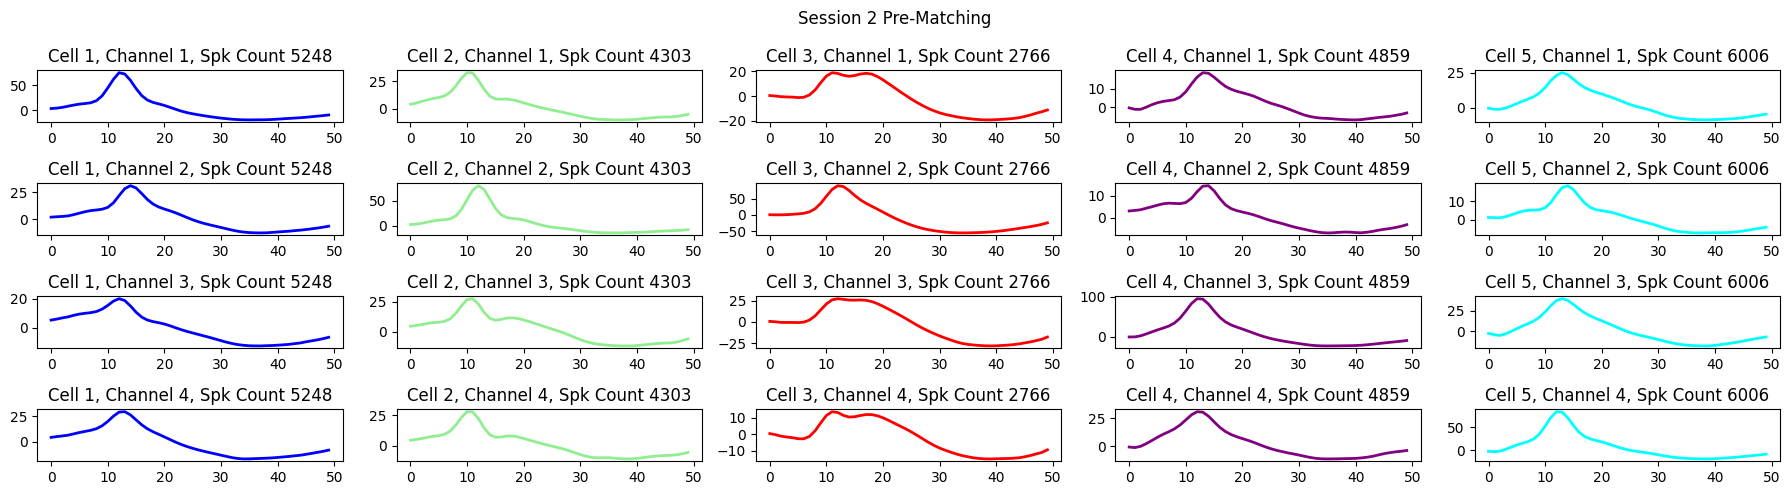

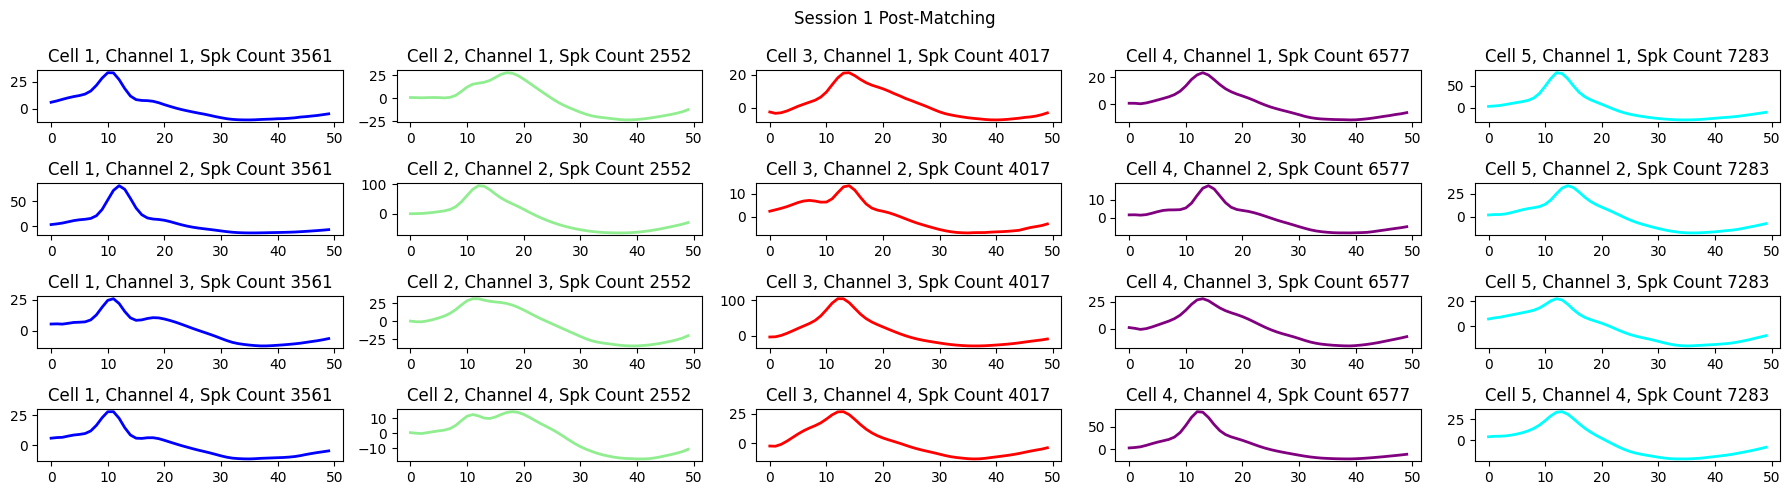

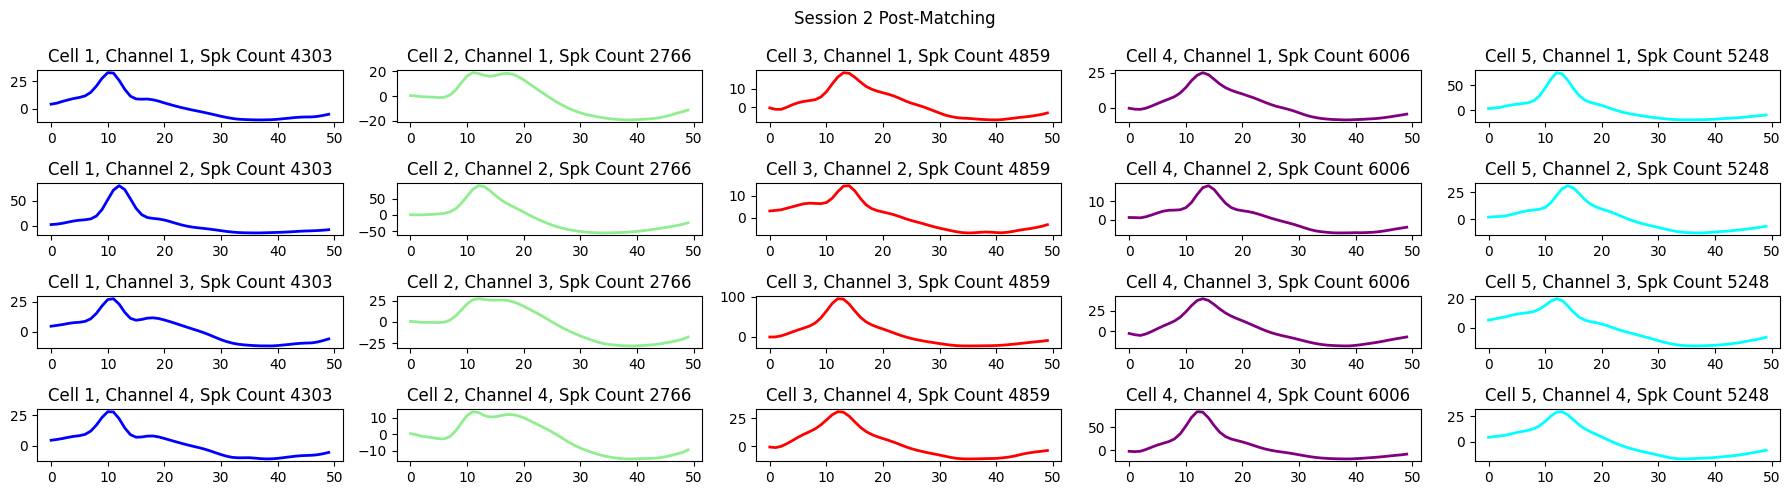

AttributeError: 'Session' object has no attribute 'cells'

In [14]:
qualityCheck(matched_study, unmatched_study)

In [ ]:
def switch_cells(animal_id, first_cell_id, second_cell_id):
    for 